# Final Project - BIOF509
## Spring 2020 - Emily Yaklich



### Project Goal: Create a classification model that will be able to predict if a protein will be alpha helical transmembrane or not based on sequence features
Will be able to compare this model to already existing transmembrane prediction models and build a foundation for the creation of more complex models (predicting specific helix residues or protein-protein interface residues)

### Code Overview
1. Obtain FASTA files with the transmembrane (TM) and non-transmemrane (non-TM) protein sequences
2. Using the [iFeature](https://github.com/Superzchen/iFeature) python package, acquire sequence features in terms of Amino Acid Compositon and Grouped Dipeptide Composition
3. Read in the data as dataframes and create one feature table for both TM and non-TM feature data
4. Create and train a Random Forest Classifier model in order to classify the sequence as TM or non-TM
5. Plot an ROC curve and confusion matrix to better understand the model

### Links to data
- Transmembrane sequence dataset from the [PDBTM database](http://pdbtm.enzim.hu/?_=/download/files): http://pdbtm.enzim.hu/data/pdbtm_alpha_nr.seq (The downloaded data is the non-redundant alpha in the sequences column on 05/05/2020 with 971 sequences)
- Non-transmembrane sequence dataset from the [TMHMM negative testing set](http://www.cbs.dtu.dk/~krogh/TMHMM/): http://www.cbs.dtu.dk/~krogh/TMHMM/PDBseqs.fasta (downloaded on 05/05/2020 with 645 sequences)

### Use iFeature to extract sequence features from the protein sequences
iFeature can be downloaded [here](https://github.com/Superzchen/iFeature)

In [1]:
import os
data_path = os.getcwd() + '/data'

In [2]:
# TM sequences getting Amino Acid Composition features: 
!python iFeature/iFeature.py --file {data_path}/pdbtm_alpha_nr.seq.txt --type AAC --out {data_path}/TM_sequence_features_aac.tsv

Descriptor type: AAC


In [3]:
# TM sequences getting Grouped Dipeptide Composition features:
!python iFeature/iFeature.py --file {data_path}/pdbtm_alpha_nr.seq.txt --type GDPC --out {data_path}/TM_sequence_features_gdpc.tsv

Descriptor type: GDPC


In [4]:
# Non-TM sequences getting Amino Acid Composition features:
!python iFeature/iFeature.py --file {data_path}/PDBseqs.fasta_nonTM.txt --type AAC --out {data_path}/non_TM_sequence_features_aac.tsv 

Descriptor type: AAC


In [5]:
# Non-TM sequences getting Grouped Dipeptide Composition features:
!python iFeature/iFeature.py --file {data_path}/PDBseqs.fasta_nonTM.txt --type GDPC --out {data_path}/non_TM_sequence_features_gdpc.tsv 

Descriptor type: GDPC


### Read in the sequence feature data

In [6]:
import pandas as pd
# read in the transmembrane data
TM_aac = pd.read_csv(data_path +'/TM_sequence_features_aac.tsv', sep='\t')
TM_gdpc = pd.read_csv(data_path + '/TM_sequence_features_gdpc.tsv', sep='\t')
# merge the two dataframes 
TM_data = pd.merge(TM_aac, TM_gdpc, on='#')
# add a 'tm identity' column that will indicate whether a protein is TM or not (2 means it is TM)
TM_data['tm identity'] = 2

In [7]:
non_TM_aac = pd.read_csv(data_path + '/non_TM_sequence_features_aac.tsv', sep='\t')
non_TM_gdpc = pd.read_csv(data_path +'/non_TM_sequence_features_gdpc.tsv', sep='\t')
# merge the two dataframes
non_TM_data = pd.merge(non_TM_aac, non_TM_gdpc, on='#')
# add a 'tm identity' column that will indicated whether a protein is TM or not (1 means it is non-TM)
non_TM_data['tm identity'] = 1

In [8]:
# combine the two dataframes to create the dataset containing all features
all_seq_features = TM_data.append(non_TM_data)
all_seq_features = all_seq_features.set_index('#')

### Visualize first five rows of data

In [9]:
all_seq_features.head()

,A,C,D,E,F,G,H,I,K,L,...,negativecharger.aromatic,negativecharger.postivecharger,negativecharger.negativecharger,negativecharger.uncharger,uncharger.alphaticr,uncharger.aromatic,uncharger.postivecharger,uncharger.negativecharger,uncharger.uncharger,tm identity
#,,,,,,,,,,,,,,,,,,,,,
3a0b_Z,0.096774,0.000000,0.032258,0.000000,0.080645,0.064516,0.000000,0.080645,0.016129,0.177419,...,0.016393,0.016393,0.000000,0.000000,0.081967,0.032787,0.016393,0.016393,0.032787,2
5a1s_A,0.107143,0.013393,0.026786,0.035714,0.055804,0.102679,0.008929,0.109375,0.040179,0.118304,...,0.004474,0.008949,0.008949,0.004474,0.098434,0.017897,0.022371,0.020134,0.038031,2
4a2n_B,0.036082,0.005155,0.025773,0.056701,0.082474,0.056701,0.020619,0.118557,0.087629,0.113402,...,0.015544,0.005181,0.020725,0.015544,0.067358,0.041451,0.031088,0.010363,0.025907,2
6a2j_A,0.090615,0.022654,0.009709,0.029126,0.077670,0.067961,0.032362,0.106796,0.032362,0.148867,...,0.006494,0.003247,0.003247,0.016234,0.113636,0.035714,0.016234,0.009740,0.048701,2
6a2w_A,0.089820,0.000000,0.065868,0.083832,0.083832,0.119760,0.011976,0.053892,0.035928,0.113772,...,0.024096,0.012048,0.024096,0.036145,0.096386,0.018072,0.000000,0.012048,0.042169,2


### Visualize shape of the data

In [10]:
all_seq_features.shape

(1616, 46)

### Look for missing observations in the dataset

In [11]:
all_seq_features.isnull().sum()

# there are no missing oberservations in the dataset!

A                                  0
C                                  0
D                                  0
E                                  0
F                                  0
G                                  0
H                                  0
I                                  0
K                                  0
L                                  0
M                                  0
N                                  0
P                                  0
Q                                  0
R                                  0
S                                  0
T                                  0
V                                  0
W                                  0
Y                                  0
alphaticr.alphaticr                0
alphaticr.aromatic                 0
alphaticr.postivecharger           0
alphaticr.negativecharger          0
alphaticr.uncharger                0
aromatic.alphaticr                 0
aromatic.aromatic                  0
a

### Problem Statement
Transmembrane proteins have different properties and functions compared to soluble proteins, so it is important to be able to identify transmembrane proteins from soluble proteins. Currently transmembrane prediction algorithms exist, but is it possible to create my own model that can reproduce these predictions? Can I build a model to differentiate a transmembrane protein from a soluble protein from sequence information alone?

### y-variable 
The y-variable or labels or target prediction is the transmembrane identity of a protein sequence. In this dataset, it will the the 'tm identity' column with either a 2 for a transmembrane identity or 1 for a non-transmembrane identity

### Build and test a Random Forest Classifier Model with tuned hyperparameters

In [12]:
# separate the target labels and the rest of the features in the dataset
import numpy as np
# labels are the values we will to predict (TM or non-TM)
labels = np.array(all_seq_features['tm identity'])
# remove the labels from the features
# axis 1 refers to the columns
features= all_seq_features.drop('tm identity', axis = 1)
# save feature names
feature_list = list(features.columns)
# convert df to numpy array
features = np.array(features)

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# split the data into training and testing sets
# X_train = training features, y_train = training labels, X_test = testing features, y_test = testing labels
X_train, X_test, y_train, y_test = train_test_split(features, 
                                            labels, test_size = 0.3, random_state = 42)

rf = RandomForestClassifier(random_state=42)

# hyperparameter grid
param_grid = {'max_features': ['auto', None, 'log2'],'n_estimators': [100, 500, 1000]}

# instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid)

grid_search.fit(X_train, y_train)
# save the optimized 
best_tuned_model = grid_search.best_estimator_

# fit 
best_tuned_model.fit(X_train, y_train)

# predict 
model_predictions = best_tuned_model.predict(X_test)

# calculate mean predicted class probabilities 
model_probs = best_tuned_model.predict_proba(X_test)[:, 1]

# test
mse = mean_squared_error(y_test, model_predictions)
print('Mean Squared Error:', round(mse, 2))

Mean Squared Error: 0.11


### Accuracy of the model

In [14]:
# calculate the absolute errors
errors = abs(model_predictions - y_test)
# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.09 %.


In [15]:
# find the average number of nodes and the depth for the decision trees 
n_nodes = []
max_depths = []
for ind_tree in best_tuned_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes: {int(np.mean(n_nodes))}')
print(f'Average maximum depth: {int(np.mean(max_depths))}')

Average number of nodes: 193
Average maximum depth: 12


### ROC Curve

The AUC is: 0.9


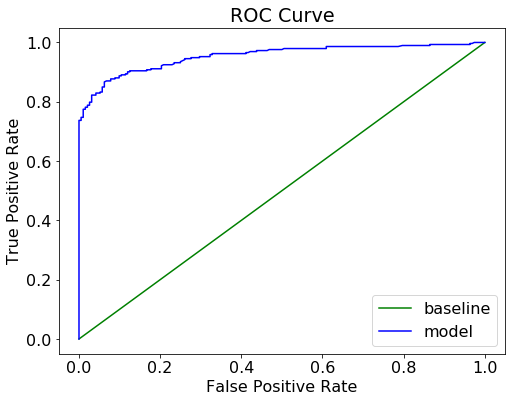

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# calculate false positive rates and true positive rates
# the base rates are without the model
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))],pos_label=2)
model_fpr, model_tpr, _ = roc_curve(y_test, model_probs, pos_label=2)

# plot the true postive and false positive rates as an ROC curve 
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16    
plt.plot(base_fpr, base_tpr, 'green', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'b', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve');
roc_auc = roc_auc_score(y_test, model_predictions)
print('The AUC is:', round(roc_auc,2))

The true positive rate (TPR) is plotted against the false positive rate (FPR) for the baseline and the model. The baseline (blue line) describes the rates with no predictive model, so where TPR=FDR. We can see that the predictive value increases when the model is applied to the data (red line). 

### Confusion Matrix

[[177  15]
 [ 37 256]]


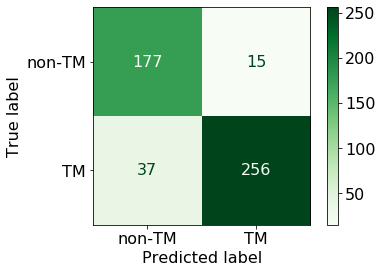

In [21]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# create a confusion matrix
conf_mat = confusion_matrix(y_test, model_predictions)
print(conf_mat)

# create a confusion matrix plot
labels = ['non-TM', 'TM']
plot = plot_confusion_matrix(best_tuned_model, X_test, y_test,
display_labels=labels, values_format='.3g', cmap=plt.cm.Greens)

Confusion matrix illustrates the true positive (TP), false positive (FP), true negative (TN) and false negative (FN) predictions in from the test dataset. The top left corner shows the proteins predicted as non-TM and are truly non-TM and the bottom right corner shows the proteins predicted as TM and are truly TM. The bottom left corner displays the proteins predicted as TM but are truly non-TM and the top right corner shows the proteins that are predicted as TM but are truly non-TM. We can see that the true positive and true negative predictions are much greater than the false predictions.

### Feature Importances

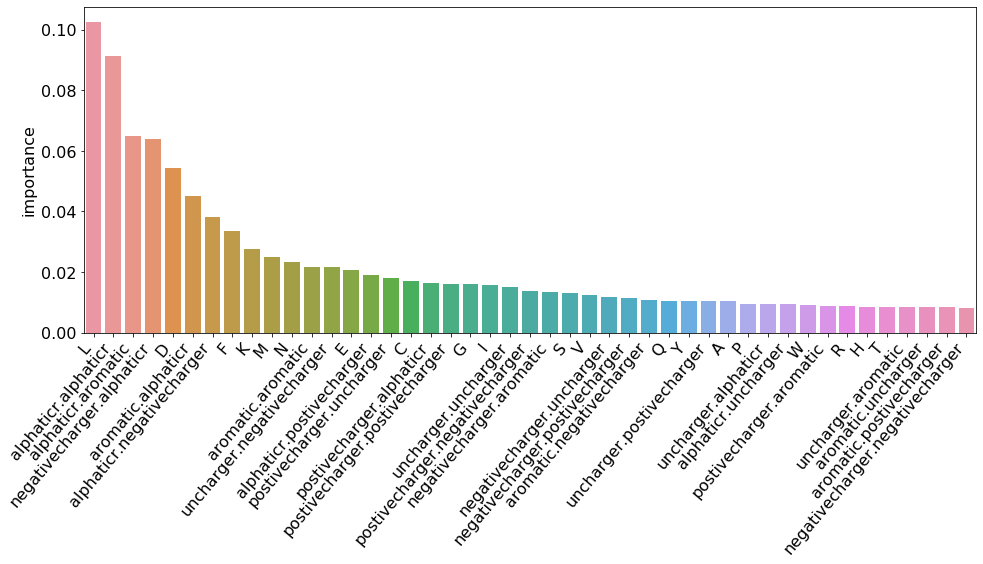

In [23]:
import seaborn as sns
# identify which features contribute the most to the model and put into a dataframe
feature_importances = pd.DataFrame(best_tuned_model.feature_importances_, index = feature_list,
                      columns=['importance']).sort_values('importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(16,6))
ax = sns.barplot(x=feature_importances.index.values, y='importance' ,data=feature_importances)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

Feature importances show how much each feature in the dataset contributes to the model. From this plot, we can see that the top five features are: Lysine resiudes, aliphatic-aliphatic residue pairs, aliphatic-aromatic residue pairs, aromatic-aliphatic residue pairs, and aspartic acid residues.

## Conclusion

Model that will be able to classify a protein sequence as transmembrane or not is able to predict with ~93% accuracy. The purpose of creating this model was to build a foundation and familiarize myself with machine learning protocols and now I can compare this model to already existing transmembrane prediction algorithms and then further improve this model to possibly classify specific TM helix regions and/or membrane protein interfaces.

### References:

- Chen Z, Zhao P, Li F, Leier A, Marquez-Lago TT, Wang Y, Webb GI, Smith AI, Daly RJ* , Chou KC* , Song J* . iFeature: a python package and web server for features extraction and selection from protein and peptide sequences. Bioinformatics, 2018, doi: 10.1093/bioinformatics/bty140.
- https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://github.com/biof509/spring2020
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html